# Train an XNN model

This notebook shows how to implement using Keras (with TensorFlow backend) an Explainable Neural Network as described in [Explainable Neural Networks based on Additive Index Models](https://arxiv.org/pdf/1806.01933.pdf).

The architecture of the network is as follows:

![XNN Architecture](xnn_arch.png)


And consists of three layers:

(i) The projection layer (first hidden layer) using linear activation function

(ii) Subnetworks, which learn a potentially nonlinear transformation of the input

(iii) Combination layer calculates a weighted sum the output of the ridge functions

In [11]:
import numpy as np
import pandas as pd
import shap
import subprocess
import sys
import pydot

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Dropout, Input, Lambda, Concatenate
from keras.models import Model
from keras.utils import plot_model

#import plotly.plotly as py
#import chart_studio.plotly as py
#import plotly.tools as tls
import matplotlib.pyplot as plt
    
from timeit import default_timer as timer
import tensorflow as tf
from keras import backend as K


In [12]:
seed = 12345

np.random.seed(seed)

my_init = keras.initializers.RandomUniform(seed=seed)


def projection_initializer(shape, dtype=None):
   
    inps = shape[0]
    subs = shape[1]
    if subs > pow(inps, 2) - 1:
        raise ValueError("Currently we support only up to 2^features - 1 number of subnetworks.")
    
    weights = []

    for i in range(subs):
        w = [0] * inps
        w[i] = 1
        weights.append(w)
    return weights



def alpha_beta(alpha, beta, X , R):
    """ Calculate the layerwise backpropagation function """
    
    positive_values = [item for item in X if item > 0]
        
    negative_values = [item for item in X if item < 0] 
        
    ans = np.array([0.0]*len(X))
        
    
    if len(positive_values) > 0:
           
        ans += alpha*np.array([item / float(sum(positive_values)) if item > 0 else 0 for item in X])

    if len(negative_values) > 0:
 
        ans += -beta * np.array([item / float(sum(negative_values)) if item < 0 else 0 for item in X]) 

    return ans*R


def deep_lift(X_bar, X , R):
    
    """ Deep lift backpropagation function"""   
    
    ans =  np.array(X) - np.array(X_bar)
    ans = ans / (sum(X) - sum(X_bar))     
    
    return ans*R

# XNN Class

In [13]:
class XNN:
    # define base model
    def __init__(self, features, ridge_functions=3, arch=[20,12], bg_samples=100, seed=None, is_categorical=False):
        self.seed = seed
        self.bg_samples = bg_samples
        self.is_categorical = is_categorical
        
        #
        # Prepare model architecture
        #
        # Input to the network, our observation containing all the features
        input = Input(shape=(features,), name='main_input')

        # Input to ridge function number i is the dot product of our original input vector times coefficients
        ridge_input = Dense(ridge_functions,
                            name="projection_layer",
                                activation='linear')(input)
        
        self.ridge_networks = []
        # Each subnetwork uses only 1 neuron from the projection layer as input so we need to split it
        ridge_inputs = Lambda( lambda x: tf.split(x, ridge_functions, 1), name='lambda_1' )(ridge_input)
        for i, ridge_input in enumerate(ridge_inputs):
            # Generate subnetwork i
            mlp = self._mlp(ridge_input, i, arch)
            self.ridge_networks.append(mlp)
                    
        added = Concatenate(name='concatenate_1')(self.ridge_networks)
        
        # Add the correct output layer for the problem
        if self.is_categorical:
            out = Dense(1, activation='sigmoid', input_shape= (ridge_functions, ), name='main_output')(added)
        else:
            out = Dense(1, activation='linear', input_shape= (ridge_functions, ), name='main_output')(added)
            
        self.model = Model(inputs=input, outputs=out)
        
        optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)
        
        # Use the correct loss for the problem
        if self.is_categorical:
            self.model.compile(loss={'main_output': 'binary_crossentropy'}, optimizer=optimizer)
        else:
            self.model.compile(loss={'main_output': 'mean_squared_error'}, optimizer=optimizer)

        self.explainer = None
                
        
    def _mlp(self, input, idx, arch=[20,12], activation='relu'):
        if len(arch) < 1:
            return #raise exception
        
        # Hidden layers
        mlp = Dense(arch[0], activation=activation, name='mlp_{}_dense_0'.format(idx), kernel_initializer=my_init)(input)
        for i, layer in enumerate(arch[1:]):
            mlp = Dense(layer, activation=activation, name='mlp_{}_dense_{}'.format(idx, i+1), kernel_initializer=my_init)(mlp)
         

        # Output of the MLP
        mlp = Dense(1, 
                    activation='linear', 
                    name='mlp_{}_dense_last'.format(idx), 
                    kernel_regularizer=keras.regularizers.l1(1e-3),
                    kernel_initializer=my_init)(mlp)
        
        return mlp
    
    def print_architecture(self):
        self.model.summary()
    
    def fit(self, X, y, epochs=5, batch_size=128, validation_split=0.0, verbose=0):
        inputs = {'main_input': X}

        self.model.fit(inputs, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
        
        #
        # Prepare the explainer
        # 
        np.random.seed(self.seed)
        if isinstance(X, pd.DataFrame):
            background = X.iloc[np.random.choice(X.shape[0], self.bg_samples, replace=False)]
        else:
            background = X[np.random.choice(X.shape[0], self.bg_samples, replace=False)]

        # Explain predictions of the model on the subset
        self.explainer = shap.DeepExplainer(self.model, background)
                    
        
    def predict(self, X, pred_contribs=False):
        pred_start = timer()
        preds = self.model.predict(X)
        pred_end = timer()
        print("Predictions took {}".format(pred_end - pred_start))

        if pred_contribs:
            explainer_start = timer()

            self.shap_values = self.explainer.shap_values(X)

            explainer_end = timer()
            print("Explainer took {}".format(explainer_end - explainer_start))

            concat_start = timer()

            preds = np.concatenate((preds, self.shap_values[0], preds), axis=1)
            preds[:,-1] = self.explainer.expected_value

            concat_end = timer()
            print("Concat took {}".format(concat_end - concat_start))
        return preds
    
    def plot_shap(self, X):
        shap.summary_plot(self.shap_values, X)
        

# Load dataset

In [14]:
# Load the dataset

xnn_data_dir = '~/article-information-2019/data/xnn_output/'

DATA=pd.read_csv(xnn_data_dir + 'train_transformed.csv')
#DATA = DATA.iloc[0:10000,:]
TEST=pd.read_csv(xnn_data_dir + 'test_transformed.csv')



# Select features and split into target and feature sets
selected_vars = ['term_360', 'conforming']
selected_vars += ['debt_to_income_ratio_missing','loan_amount_std', 'loan_to_value_ratio_std']
selected_vars += ['no_intro_rate_period_std', 'intro_rate_period_std']
selected_vars += ['property_value_std', 'income_std', 'debt_to_income_ratio_std']


target_var = "high_priced"

X=DATA[selected_vars].values
Y=DATA[target_var].values
TEST_X = TEST[selected_vars].values
TEST_Y = TEST[target_var].values
features = X.shape[1]

In [15]:
DATA.columns

Index(['Unnamed: 0', 'high_priced', 'term_360', 'conforming', 'black', 'asian',
       'white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female',
       'agegte62', 'agelt62', 'cv_fold', 'debt_to_income_ratio_missing',
       'loan_amount_std', 'loan_to_value_ratio_std',
       'no_intro_rate_period_std', 'intro_rate_period_std',
       'property_value_std', 'income_std', 'debt_to_income_ratio_std'],
      dtype='object')

# Fit XNN

In [16]:
# Initialize the XNN
is_cat = True
xnn = XNN(features=features, ridge_functions=features,arch=[20, 12], is_categorical= is_cat)

#plot_model(xnn.model, to_file='model_regression.png')
xnn.print_architecture()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 10)           0                                            
__________________________________________________________________________________________________
projection_layer (Dense)        (None, 10)           110         main_input[0][0]                 
__________________________________________________________________________________________________
lambda_1 (Lambda)               [(None, 1), (None, 1 0           projection_layer[0][0]           
__________________________________________________________________________________________________
mlp_0_dense_0 (Dense)           (None, 20)           40          lambda_1[0][0]                   
____________________________________________________________________________________________

In [17]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())

print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.13.1
Eager mode:  False
GPU is available


In [18]:
# Train the xnn
xnn.fit(X, Y, epochs=10, batch_size=1024, validation_split=0.25, verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 120253 samples, validate on 40085 samples
Epoch 1/10
120253/120253 [==============================] - 5s 45us/step - loss: 0.4877 - val_loss: 0.3117
Epoch 2/10
120253/120253 [==============================] - 4s 31us/step - loss: 0.2923 - val_loss: 0.2812
Epoch 3/10
120253/120253 [==============================] - 4s 30us/step - loss: 0.2762 - val_loss: 0.2743
Epoch 4/10
120253/120253 [==============================] - 3s 29us/step - loss: 0.2726 - val_loss: 0.2723
Epoch 5/10
120253/120253 [==============================] - 4s 30us/step - loss: 0.2712 - val_loss: 0.2713
Epoch 6/10
120253/120253 [==============================] - 4s 30us/step - loss: 0.2703 - val_loss: 0.2703
Epoch 7/10
120253/120253 [==============================] - 4s 34us/step - loss: 0.2695 - val_loss: 0.2695
Epoch 8/10
120253/120253 [==============================] - 4s 30us/step - loss: 0.2688 - val_loss: 0.2689
Epoch 9/10
120253/120253 [===================

# Record layer information
# Plot projection layer

projection_layer
projection_layer
[ 0.09037666  0.00578727  0.14086425 -0.5918287  -0.45979732  0.35110733
  0.01584978 -0.6062814   0.00289937  0.49064526]


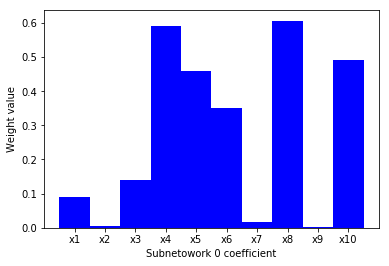

[-0.40317136  0.35665756  0.3649473   0.50453734 -0.27210224 -0.2901386
  0.6751373   0.6004405   0.30229744  0.6057854 ]


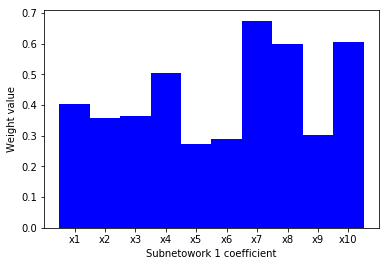

[ 0.0286647   0.5516577  -0.4149843   0.7083524  -0.43310675  0.27419242
  0.3315289   0.22838877  0.00849197 -0.41340908]


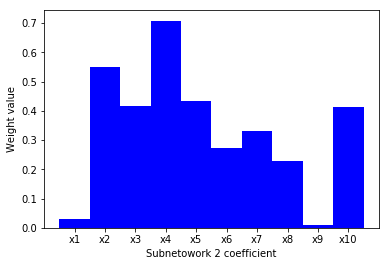

[-0.1175212   0.29386574  0.16791627  0.32470083 -0.60266095  0.69498324
 -0.04377802 -0.31227392 -0.42281425 -0.5242342 ]


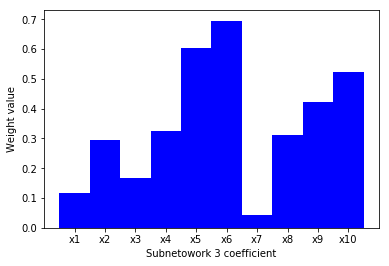

[-0.2322883  -0.00127205  0.06671108 -0.53555894  0.6314585  -0.9697304
  0.9611524  -0.4798022  -0.18052346  0.04523513]


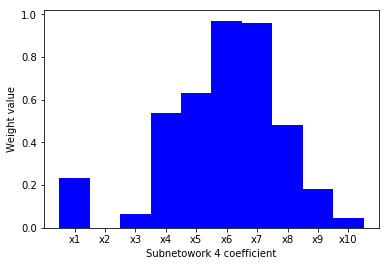

[-0.45713612 -0.46781316  0.08166003  0.25089285  0.8044204  -0.0322221
  1.1704158  -0.23647153  0.3089814   0.4616512 ]


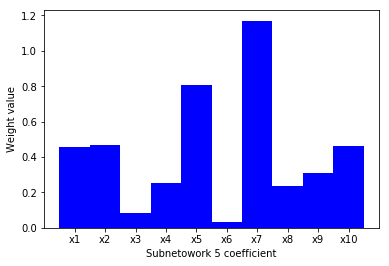

[ 0.5313631   0.03614993  0.40588132  0.7820677  -0.41112423 -0.17422463
 -0.03897676 -0.04421796  0.3388597  -0.38801232]


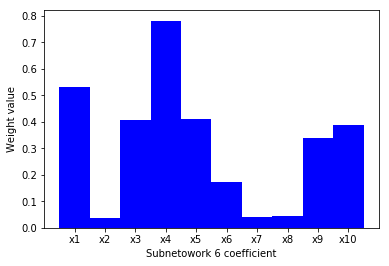

[ 0.51604444  0.5281431   0.22168198 -0.315467    0.30185848  0.21489853
 -0.20271574 -0.33212408  0.17603861  0.14932853]


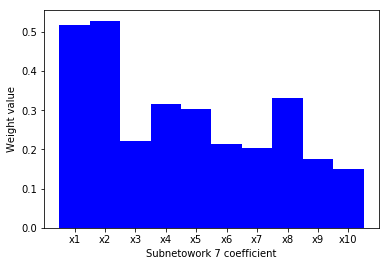

[-0.14884321 -0.12287783  0.52154905  0.06169235  1.1411113  -1.0831351
  0.57169574 -0.7060243   1.1291438   0.07697581]


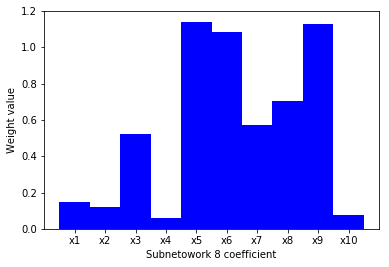

[ 0.21584105  0.6130673   0.08145577  0.80050725 -0.14294036 -0.1658855
  0.41691878  0.765357   -0.6153051  -0.17309412]


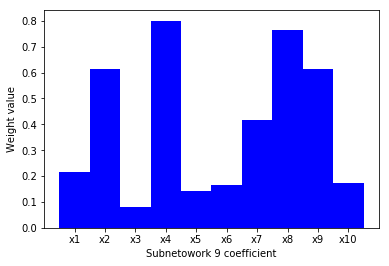

lambda_1
No Bias
mlp_0_dense_0
mlp_1_dense_0
mlp_2_dense_0
mlp_3_dense_0
mlp_4_dense_0
mlp_5_dense_0
mlp_6_dense_0
mlp_7_dense_0
mlp_8_dense_0
mlp_9_dense_0
mlp_0_dense_1
mlp_1_dense_1
mlp_2_dense_1
mlp_3_dense_1
mlp_4_dense_1
mlp_5_dense_1
mlp_6_dense_1
mlp_7_dense_1
mlp_8_dense_1
mlp_9_dense_1
mlp_0_dense_last
mlp_1_dense_last
mlp_2_dense_last
mlp_3_dense_last
mlp_4_dense_last
mlp_5_dense_last
mlp_6_dense_last
mlp_7_dense_last
mlp_8_dense_last
mlp_9_dense_last
concatenate_1
No Bias
main_output
[array([[ 0.75635177],
       [ 0.804725  ],
       [-0.20998007],
       [-0.8604771 ],
       [-0.6668182 ],
       [-0.4309467 ],
       [-0.12412248],
       [ 0.25893518],
       [-0.44230908],
       [ 0.82847023]], dtype=float32), array([-0.07208647], dtype=float32)]


In [19]:
# Record the inputs, outputs, weights, and biases
import scipy as sp

int_output = {}
int_output2 = {}
int_weights = {}
int_bias = {}
int_input = {}

original_activations = {}


x_labels = list(map(lambda x: 'x' + str(x+1), range(features)))

intermediate_output = []

# Record and plot the projection weights
# 
weight_list = []
for layer in xnn.model.layers:
    
    layer_name = layer.get_config()['name']
    if layer_name != "main_input":
        print(layer_name)
        weights = layer.get_weights()
        
        
        # Record the biases
        try:
            bias = layer.get_weights()[1]
            int_bias[layer_name] = bias
        except:
            print("No Bias")
            
                       
        # Record outputs for the test set
        intermediate_layer_model = Model(inputs=xnn.model.input, outputs=xnn.model.get_layer(layer_name).output)
        if (is_cat) and (layer_name == 'main_output'):
            int_output[layer_name] = sp.special.logit(intermediate_layer_model.predict(TEST_X))
            int_output[layer_name + "_p"] = intermediate_layer_model.predict(TEST_X)
        else:
            int_output[layer_name] = intermediate_layer_model.predict(TEST_X)
        
        # Record the outputs from the training set
        if is_cat and (layer_name == 'main_output'):
            original_activations[layer_name] = sp.special.logit(intermediate_layer_model.predict(X))   
            original_activations[layer_name + "_p"] = intermediate_layer_model.predict(X)
        else:
            original_activations[layer_name] = intermediate_layer_model.predict(X)        


        # Record other weights, inputs, and outputs
        int_weights[layer_name] = weights
        int_input[layer_name] = layer.input
        int_output2[layer_name] = layer.output
        
        
    if "projection_layer" in layer.get_config()['name']:
        
        print(layer.get_config()['name'])
        
        # Record the weights for each projection layer
        weights = [np.transpose(layer.get_weights()[0])]

        weight_list2=[]
        for i, weight in enumerate(weights[0]):
            weight_list.append(weight)
            weight_list2.append(list(np.reshape(weight, (1,features))[0]))
        
            print(weight)
            
            # Plot weights
            plt.bar(x_labels, abs(np.reshape(weight, (1,features))[0]), 1, color="blue")
            plt.xlabel("Subnetowork {} coefficient".format(i))
            plt.ylabel("Weight value")
            plt.show()

    if "main_output" in layer.get_config()['name']:
        weights_main = layer.get_weights()
        print(weights_main)
        
#pd.DataFrame(weight_list2).to_csv("wp_"+lll+".csv", index=False)

# Calculate the feature importances

In [20]:
# Calculate ridge and input function local feature importances   
item = 0


feature_output = []
feature_output2 = []
feature_output3 = []

# Find the average outputs
S_bar = sum(original_activations["main_output"])/len(original_activations["main_output"])
# original_activations[layer_name]
output_weights = np.array([int_weights["main_output"][0][ii][0] for ii in range(features)])
output_Z_bar = sum(original_activations["concatenate_1"]*output_weights)/len(original_activations["concatenate_1"])


# For each ridge function calculate the average input activation
input_Z_bar = {}
for ridge_num in range(features):   
    input_weights = np.array([int_weights["projection_layer"][0][ii][ridge_num] for ii in range(features)])
    input_Z_bar[ridge_num] = sum(X*input_weights)/len(X)
    
    
# For each test instance, calculate the feature importance scores    
for test_num in range(len(TEST_X)):
    
    # Calculate the output activations
    activation_list=[int_weights["main_output"][0][ii][0]*int_output["concatenate_1"][test_num][ii] for ii in range(features)]
    
    
    # Calculate layerwise backpropagaiton to the ridge functions
    # For classification, change this to the inverse sigmoid of the output
    features_ab = alpha_beta(2, 1, activation_list , int_output["main_output"][test_num][0])
    features_ab2 = alpha_beta(2, 1, activation_list , int_output["main_output"][test_num][0]-S_bar)
    
    # Calculate deep lift backpropagation to the ridge functions
    features_dl = deep_lift(output_Z_bar, activation_list , int_output["main_output"][test_num][0]-S_bar)
      
        
    # Calculate the deep lift and layerwise information scores for the input layer
    input_scores = []
    input_scores_dl = []
    input_scores2 = []
    input_scores_dl2 = []
    for ridge_num in range(features):
        weights = int_weights["projection_layer"][0][ridge_num]
        output = TEST_X[test_num,:]
        
        # [int_weights["projection_layer"][0][ii][0] for ii in range(features)]
        
        # Calculate the activations from the projection layer
        act = TEST_X[test_num,:]*np.array([int_weights["projection_layer"][0][ii][ridge_num] for ii in range(features)])
    
        # Input relevance scores for a single ridge function
        input_scores += list(alpha_beta(2,1, act, features_ab[ridge_num]))
        input_scores_dl += list(deep_lift(input_Z_bar[ridge_num], act, features_dl[ridge_num]))
        input_scores2 += list(alpha_beta(2,1, act, features_ab2[ridge_num]))

        # print(sum(TEST_X[0,:]*np.array([int_weights["projection_layer"][0][ii][0] for ii in range(features)]))+int_bias["projection_layer"][0])
        
    # Sum the contribution of the variable importance from each of the projections
    input_sum = [sum(input_scores[ii+features*jj] for jj in range(features)) for ii in range(features)] 
    input_sum2 = [sum(input_scores2[ii+features*jj] for jj in range(features)) for ii in range(features)] 
    input_sum_dl = [sum(input_scores_dl[ii+features*jj] for jj in range(features)) for ii in range(features)] 
    input_abs_sum = [sum(abs(input_scores[ii+features*jj]) for jj in range(features)) for ii in range(features)] 
    
    # Recored the feature importance informaiton for this instance
    feature_output.append(input_sum+input_abs_sum+[int_output["main_output"][test_num][0]]+list(features_ab)+input_scores)
    feature_output2.append(input_sum+list(features_ab)+input_sum_dl + list(features_dl))
    feature_output3.append(input_sum2+list(features_ab2)+input_sum_dl + list(features_dl))


/home/kimm/venv_information_paper/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/home/kimm/venv_information_paper/lib/python3.5/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/home/kimm/venv_information_paper/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/home/kimm/venv_information_paper/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/home/kimm/venv_information_paper/lib/python3.5/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


# Find and plot the ridge functions

No handles with labels found to put in legend.


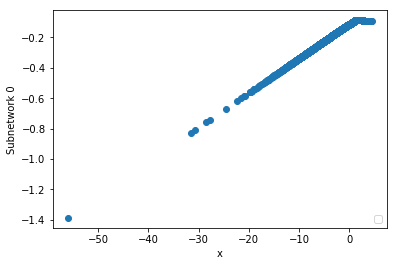

No handles with labels found to put in legend.


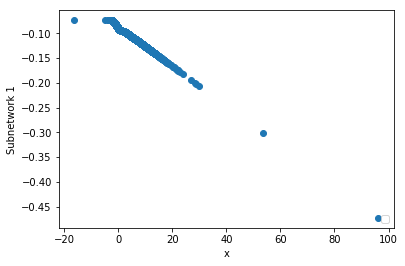

No handles with labels found to put in legend.


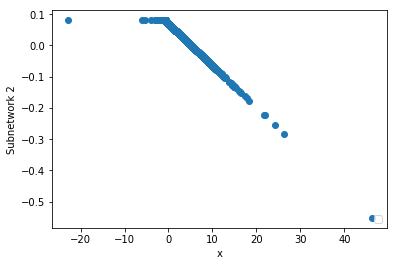

No handles with labels found to put in legend.


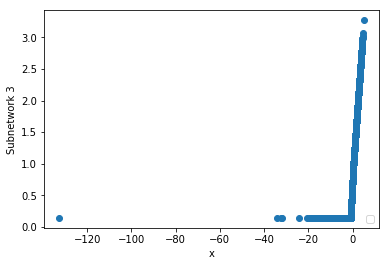

No handles with labels found to put in legend.


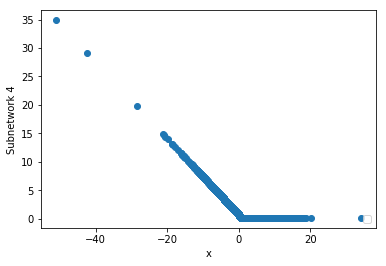

No handles with labels found to put in legend.


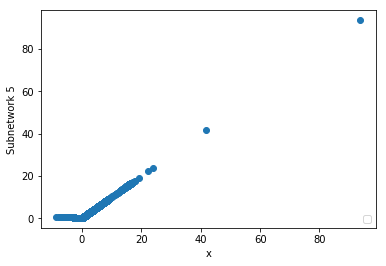

No handles with labels found to put in legend.


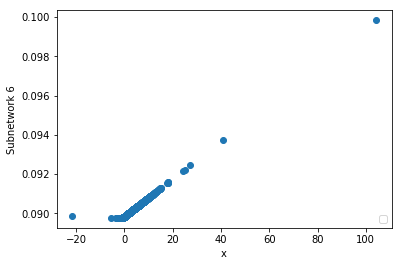

No handles with labels found to put in legend.


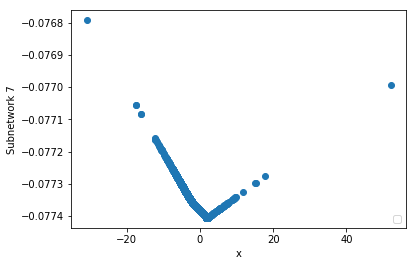

No handles with labels found to put in legend.


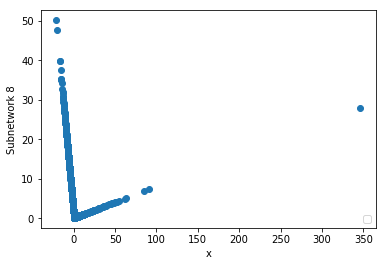

No handles with labels found to put in legend.


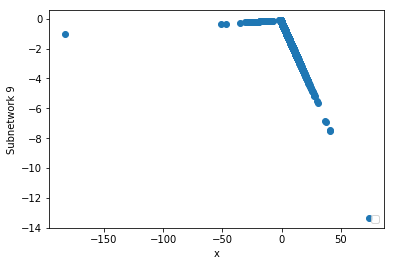

In [21]:
intermediate_output = []

for feature_num in range(features):
    intermediate_layer_model = Model(inputs=xnn.model.input,
                                 outputs=xnn.model.get_layer('mlp_'+str(feature_num)+'_dense_last').output)
    intermediate_output.append(intermediate_layer_model.predict(X))


# Record and plot the ridge functions
ridge_x = []
ridge_y = []
for weight_number in range(len(weight_list)):
    
    ridge_x.append(list(sum(X[:, ii]*weight_list[weight_number][ii] for ii in range(features))))
    ridge_y.append(list(intermediate_output[weight_number]))

    plt.plot(sum(X[:, ii]*weight_list[weight_number][ii] for ii in range(features)), intermediate_output[weight_number], 'o')
    plt.xlabel("x")
    plt.ylabel("Subnetwork " + str(weight_number))
    plt.legend(loc='lower right')
    plt.show()


In [22]:
# Make predictions on the test set

In [ ]:
preds = xnn.predict(TEST_X, pred_contribs=True)

Predictions took 3.470835603773594


In [ ]:

# Calculate the Shapley values.
shap.initjs()
shap.summary_plot(xnn.shap_values, X)

y=xnn.shap_values
ind=1


# Calculate the average feature imporatance

layerwise_average_input=np.array([0.0]*features)
layerwise_average_input2=np.array([0.0]*features)
layerwise_average_ridge=np.array([0.0]*features)
layerwise_average_ridge2=np.array([0.0]*features)
layerwise_average_shap=np.array([0.0]*features)
lift_average_input=np.array([0.0]*features)
lift_average_ridge=np.array([0.0]*features)



for ii in range(len(feature_output2)):
    layerwise_average_input += np.array(feature_output2[ii][0:features])
    layerwise_average_ridge += np.array(feature_output2[ii][features:(2*features)])
    layerwise_average_input2 += np.array(feature_output3[ii][0:features])
    layerwise_average_ridge2 += np.array(feature_output3[ii][features:(2*features)])
    lift_average_input += np.array(feature_output2[ii][(2*features):(3*features)])
    lift_average_ridge += np.array(feature_output2[ii][(3*features):(4*features)])
    layerwise_average_shap += np.array(y[0][ii])
     
layerwise_average_input = layerwise_average_input/len(feature_output2)
layerwise_average_ridge = layerwise_average_ridge/len(feature_output2)
layerwise_average_input2 = layerwise_average_input2/len(feature_output2)
layerwise_average_ridge2 = layerwise_average_ridge2/len(feature_output2)
layerwise_average_shap = layerwise_average_shap/len(feature_output2)
lift_average_input = lift_average_input/len(feature_output2)
lift_average_ridge = lift_average_ridge/len(feature_output2)


SCORES = [list(layerwise_average_input), list(layerwise_average_ridge),
          list(layerwise_average_input2), list(layerwise_average_ridge2),
          list(layerwise_average_shap), list(lift_average_input),
          list(lift_average_ridge)]

# Plot feature importance scores

In [ ]:
plt.bar(x, abs(np.reshape(y[0][ind], (1,features))[0]), 1, color="blue")
plt.xlabel("Shap Score Example " + str(ind))
plt.ylabel("")
plt.show()

plt.bar(x, abs(np.reshape(feature_output2[ind][0:features], (1,features))[0]), 1, color="blue")
plt.xlabel("Input Layerwise Propagation Score Example " + str(ind))
plt.ylabel("")
plt.show()

plt.bar(x, abs(np.reshape(feature_output2[ind][features:(2*features)], (1,features))[0]), 1, color="blue")
plt.xlabel("Ridge Layerwise Propagation Score Example " + str(ind))
plt.ylabel("Weight value")
plt.show()

plt.bar(x, abs(np.reshape(feature_output2[ind][2*features:(3*features)], (1,features))[0]), 1, color="blue")
plt.xlabel("Deep Lift Input Score Example " + str(ind))
plt.ylabel("Weight value")
plt.show()


plt.bar(x, abs(np.reshape(feature_output2[ind][3*features:(4*features)], (1,features))[0]), 1, color="blue")
plt.xlabel("Deep Lift Ridge Score Example " + str(ind))
plt.ylabel("Weight value")
plt.show()
      
plt.bar(x, abs(np.reshape(layerwise_average_input, (1,features))[0]), 1, color="blue")
plt.xlabel("Input Layerwise Propagation Score Average")
plt.ylabel("")
plt.show()

plt.bar(x, abs(np.reshape(layerwise_average_ridge, (1,features))[0]), 1, color="blue")
plt.xlabel("Ridge Layerwise Propagation Score Average")
plt.ylabel("Weight value")
plt.show()


plt.bar(x, abs(np.reshape(layerwise_average_input2, (1,features))[0]), 1, color="blue")
plt.xlabel("Input Layerwise Propagation Score Average 2")
plt.ylabel("")
plt.show()

plt.bar(x, abs(np.reshape(layerwise_average_ridge2, (1,features))[0]), 1, color="blue")
plt.xlabel("Ridge Layerwise Propagation Score Average 2")
plt.ylabel("Weight value")
plt.show()


plt.bar(x, abs(np.reshape(lift_average_input, (1,features))[0]), 1, color="blue")
plt.xlabel("Input Lift Score Average")
plt.ylabel("")
plt.show()

plt.bar(x, abs(np.reshape(lift_average_ridge, (1,features))[0]), 1, color="blue")
plt.xlabel("Ridge Lift Score Average")
plt.ylabel("Weight value")
plt.show()

plt.bar(x, abs(np.reshape(layerwise_average_shap, (1,features))[0]), 1, color="blue")
plt.xlabel("Shapley Score Average")
plt.ylabel("Weight value")
plt.show()